In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5448 - loss: 0.6914 - val_accuracy: 0.6500 - val_loss: 0.6088
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7253 - loss: 0.5617 - val_accuracy: 0.7167 - val_loss: 0.5394
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8038 - loss: 0.4666 - val_accuracy: 0.8500 - val_loss: 0.4407
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8365 - loss: 0.4272 - val_accuracy: 0.8500 - val_loss: 0.4186
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9269 - loss: 0.3129 - val_accuracy: 0.9333 - val_loss: 0.2953
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9588 - loss: 0.2705 - val_accuracy: 0.9667 - val_loss: 0.2439
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9718 - loss: 0.2193 - val_accuracy: 0.8500 - val_loss: 0.3459
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9326 - loss: 0.2639 - val_accuracy: 0.9167 - val_loss: 0.2585
Epoch 9/30
5/5 ━━━━━━━━

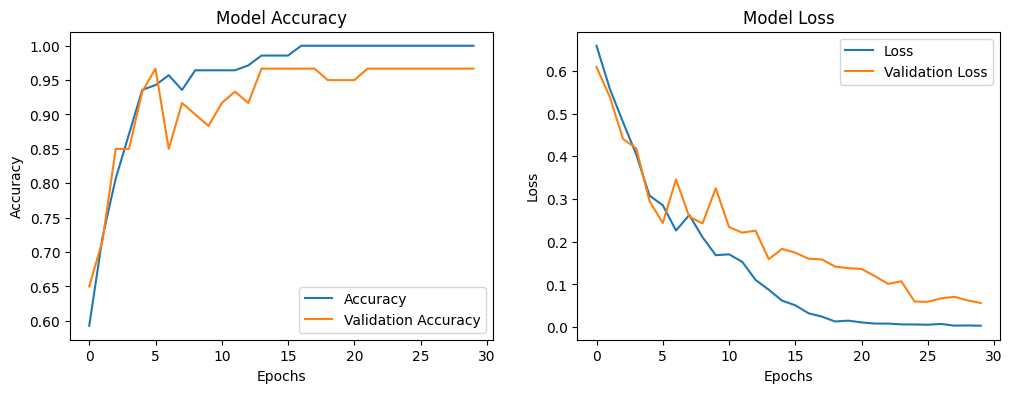

In [2]:
# 1. Set up environment (optional step to handle any environment-specific issues)
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Disable verbose TensorFlow logs

# 2. Import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
import time

# 3. Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# 4. Paths to datasets (update with your paths)
path_Z = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Update with actual path
path_S = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Update with actual path

# 5. Load data from both directories (Healthy: 0, Seizure: 1)
data_Z, labels_Z = load_data_from_directory(path_Z, label=0)  # Healthy
data_S, labels_S = load_data_from_directory(path_S, label=1)  # Seizure

# 6. Combine data and labels
if data_Z.size > 0 and data_S.size > 0:
    data_all = np.concatenate((data_Z, data_S), axis=0)
    labels_all = np.concatenate((labels_Z, labels_S), axis=0)

    # 7. Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # 8. Define the CNN + LSTM model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=False),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # 9. Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # 10. Train the model
    start_time = time.time()  # Start measuring time
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)
    end_time = time.time()  # End measuring time

    # 11. Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # 12. Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # 13. Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Test F1-Score: ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print(f"Time taken to train and evaluate the model: {end_time - start_time:.2f} seconds")

    # 14. Plot Training History (Accuracy & Loss)
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


with Standardization

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4761 - loss: 0.6432 - val_accuracy: 0.7167 - val_loss: 0.4992
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8530 - loss: 0.4340 - val_accuracy: 0.8167 - val_loss: 0.4662
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9074 - loss: 0.3538 - val_accuracy: 0.9500 - val_loss: 0.2680
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9920 - loss: 0.2051 - val_accuracy: 1.0000 - val_loss: 0.0915
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9759 - loss: 0.1309 - val_accuracy: 0.9833 - val_loss: 0.0764
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7919 - loss: 0.4456 - val_accuracy: 0.9333 - val_loss: 0.2379
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9638 - loss: 0.2047 - val_accuracy: 0.9833 - val_loss: 0.1459
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9681 - loss: 0.1444 - val_accuracy: 0.9833 - val_loss: 0.0878
Epoch 9/30


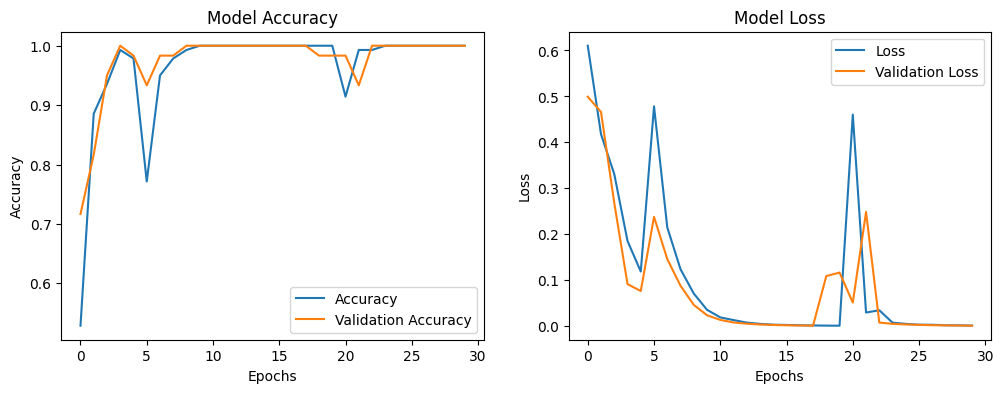

In [9]:
# 1. Set up environment (optional step to handle any environment-specific issues)
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Disable verbose TensorFlow logs

# 2. Import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
import time

# 3. Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# 4. Paths to datasets (update with your paths)
path_Z = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Update with actual path
path_S = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Update with actual path

# 5. Load data from both directories (Healthy: 0, Seizure: 1)
data_Z, labels_Z = load_data_from_directory(path_Z, label=0)  # Healthy
data_S, labels_S = load_data_from_directory(path_S, label=1)  # Seizure

# 6. Combine data and labels
if data_Z.size > 0 and data_S.size > 0:
    data_all = np.concatenate((data_Z, data_S), axis=0)
    labels_all = np.concatenate((labels_Z, labels_S), axis=0)

    # 7. Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # 8. Standardize the data using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape the data to be compatible with Conv1D input
    X_train_scaled = X_train_scaled[..., np.newaxis]  # Add a new axis for channels (Conv1D expects 3D input)
    X_test_scaled = X_test_scaled[..., np.newaxis]

    # 9. Define the model (simple CNN-LSTM architecture)
    model = Sequential()

    # 10. Add the first Conv1D layer
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))

    # 11. Add another Conv1D layer
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # 12. Add an LSTM layer
    model.add(LSTM(64, return_sequences=False))

    # 13. Dense layers and Dropout layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))  # Dropout for regularization
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    # 14. Compile the model
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])

    # 15. Train the model
    start_time = time.time()
    history = model.fit(X_train_scaled, y_train, epochs=30, batch_size=32, validation_data=(X_test_scaled, y_test))
    end_time = time.time()

    # 16. Evaluate the model
    y_pred = model.predict(X_test_scaled)
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # 17. Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # 18. Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Test F1-Score: ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print(f"Time taken for training and evaluation: {end_time - start_time:.2f} seconds")

    # 19. Plot Training History (Accuracy & Loss)
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


In [6]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.4666 - loss: nan - val_accuracy: 0.5167 - val_loss: nan
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5020 - loss: nan - val_accuracy: 0.5167 - val_loss: nan
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.5150 - loss: nan - val_accuracy: 0.5167 - val_loss: nan
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.4842 - loss: nan - val_accuracy: 0.5167 - val_loss: nan
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4772 - loss: nan - val_accuracy: 0.5167 - val_loss: nan
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.4963 - loss: nan - val_accuracy: 0.5167 - val_loss: nan
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5002 - loss: nan - val_accuracy: 0.5167 - val_loss: nan
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.5258 - loss: nan - val_accuracy: 0.5167 - val_loss: nan
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accura

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Final Evaluation Metrics:
Test Accuracy:  0.5166666666666667
Test Recall (Sensitivity):  0.0
Test Precision:  0.0
Test F1 Score:  0.0
Test Specificity:  1.0
Confusion Matrix: 
 [[31  0]
 [29  0]]
Training Duration (in seconds):  589.0912516117096


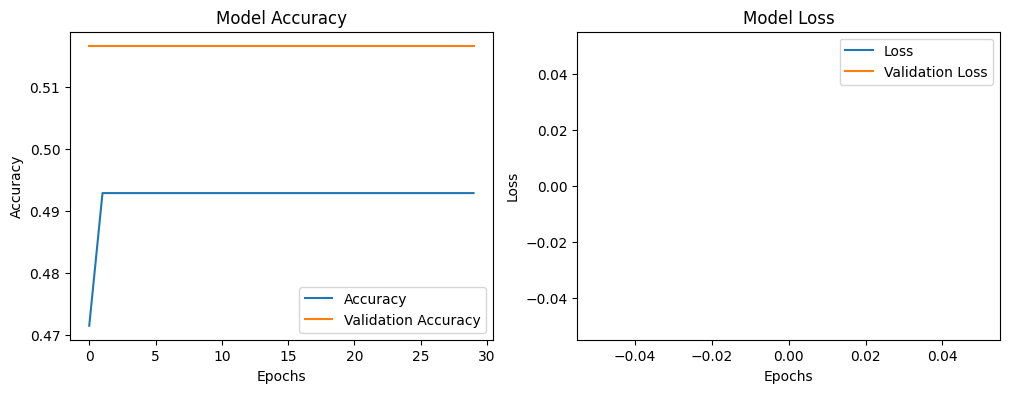

In [8]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
import time

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Z = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_S = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Z, labels_Z = load_data_from_directory(path_Z, label=0)  # Healthy (Z)
data_S, labels_S = load_data_from_directory(path_S, label=1)  # Seizure (S)

# Combine data and labels
if data_Z.size > 0 and data_S.size > 0:
    data_all = np.concatenate((data_Z, data_S), axis=0)
    labels_all = np.concatenate((labels_Z, labels_S), axis=0)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Define the CNN-LSTM model for 1D input
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, activation='relu', return_sequences=False),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()  # Start time for training duration
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)
    end_time = time.time()  # End time for training duration
    training_duration = end_time - start_time  # Training time duration

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test F1 Score: ", f1)
    print("Test Specificity: ", specificity)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Duration (in seconds): ", training_duration)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


Standarization + Op

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5781 - loss: 0.6616 - val_accuracy: 0.4833 - val_loss: 0.5913
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4802 - loss: 0.5608 - val_accuracy: 0.4833 - val_loss: 0.5171
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5542 - loss: 0.4597 - val_accuracy: 0.6167 - val_loss: 0.4690
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5804 - loss: 0.4591 - val_accuracy: 0.9167 - val_loss: 0.4318
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9525 - loss: 0.4098 - val_accuracy: 0.9333 - val_loss: 0.3869
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9727 - loss: 0.3482 - val_accuracy: 0.9500 - val_loss: 0.4138
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 996ms/step - accuracy: 0.9892 - loss: 0.2857 - val_accuracy: 0.9833 - val_loss: 0.2038
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9785 - loss: 0.1799 - val_accuracy: 0.9333 - val_loss: 0.2176
Epoch 9/30


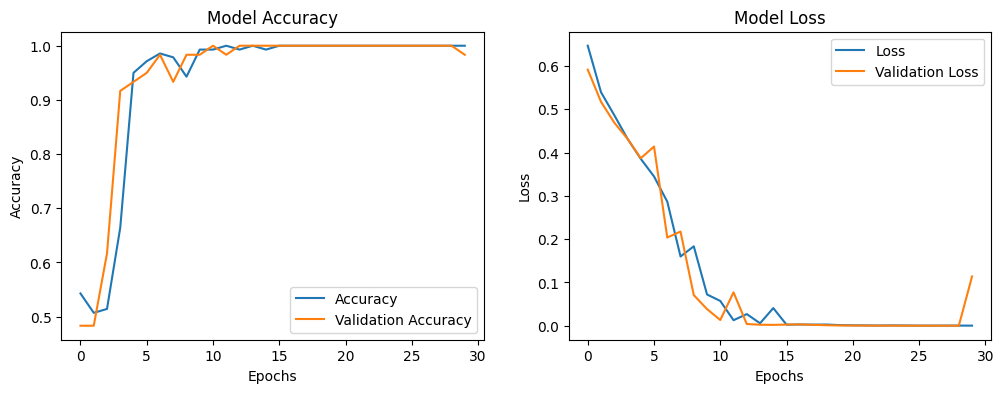

In [3]:
# 1. Set up environment (optional step to handle any environment-specific issues)
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Disable verbose TensorFlow logs

# 2. Import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
import time

# 3. Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# 4. Paths to datasets (update with your paths)
path_Z = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'  # Update with actual path
path_S = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'  # Update with actual path

# 5. Load data from both directories (Healthy: 0, Seizure: 1)
data_Z, labels_Z = load_data_from_directory(path_Z, label=0)  # Healthy
data_S, labels_S = load_data_from_directory(path_S, label=1)  # Seizure

# 6. Combine data and labels
if data_Z.size > 0 and data_S.size > 0:
    data_all = np.concatenate((data_Z, data_S), axis=0)
    labels_all = np.concatenate((labels_Z, labels_S), axis=0)

    # 7. Standardize data using StandardScaler
    scaler = StandardScaler()
    data_all = scaler.fit_transform(data_all)  # Scale the data

    # 8. Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # 9. Define the CNN + LSTM model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=False),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # 10. Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # 11. Train the model
    start_time = time.time()  # Start measuring time
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)
    end_time = time.time()  # End measuring time

    # 12. Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

    # 13. Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)  # Sensitivity
    precision = precision_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # 14. Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test Specificity: ", specificity)
    print("Test F1-Score: ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print(f"Time taken to train and evaluate the model: {end_time - start_time:.2f} seconds")

    # 15. Plot Training History (Accuracy & Loss)
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")
